<a href="https://colab.research.google.com/github/tsholofelo-mokheleli/ACIS-2023-New-Zealand/blob/main/Data%20Exploration%20of%20GSS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Exploration of GSS**

Use your gold-standard 300 posts to inform and calibrate the labeling functions for the rest.

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid", palette="Set2", font_scale=1.1)

In [70]:
gold_df = pd.read_excel("gold_standard_set.xlsx")

In [71]:
gold_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   post_id       300 non-null    object
 1   post_text     300 non-null    object
 2   subreddit     300 non-null    object
 3   source        300 non-null    object
 4   timestamp     300 non-null    object
 5   manual_label  300 non-null    object
dtypes: object(6)
memory usage: 14.2+ KB


In [72]:
gold_df.head()

,post_id,post_text,subreddit,source,timestamp,manual_label
0,1evpmju,I drink a liter of vodka took 50 Klonopin and ...,SuicideWatch,top,2024-08-19 01:25:37,HIGH
1,1hbvmo8,i wanted to use an inert gas in order to pass ...,SuicideWatch,top,2024-12-11 15:12:16,MEDIUM
2,1m1acy1,I'm tired. So tired. I could sleep all day. I ...,SuicideWatch,new,2025-07-16 11:42:24,LOW
3,1erepm8,I won't be here tomorrow so I emptied out my b...,SuicideWatch,top,2024-08-13 18:03:27,LOW
4,1m20gnq,my mom said i was a failure the other day idk ...,SuicideWatch,new,2025-07-17 06:42:08,LOW


In [73]:
classes = gold_df['manual_label'].value_counts()
print(classes)

manual_label
LOW             203
MEDIUM           45
HIGH             38
NOT_RELEVANT     14
Name: count, dtype: int64


In [74]:
# Preprocessing
def clean_post(text):
    text = str(text).lower()  # Lowercase
    text = re.sub(r'http\S+|www\S+|\.com\b|\bco\b|twitpic\S*', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove handles
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Keep only letters, numbers, spaces
    text = re.sub(r'\s+', ' ', text).strip()  # Normalize whitespace
    return text

gold_df['clean_text'] = gold_df['post_text'].apply(clean_post)
print(gold_df['clean_text'].head())

0    i drink a liter of vodka took 50 klonopin and ...
1    i wanted to use an inert gas in order to pass ...
2    im tired so tired i could sleep all day i feel...
3    i wont be here tomorrow so i emptied out my ba...
4    my mom said i was a failure the other day idk ...
Name: clean_text, dtype: object


In [75]:
# Separate by class
low_texts = gold_df[gold_df['manual_label']=='LOW']['clean_text']
medium_texts = gold_df[gold_df['manual_label']=='MEDIUM']['clean_text']
high_texts = gold_df[gold_df['manual_label']=='HIGH']['clean_text']
notr_texts = gold_df[gold_df['manual_label']=='NOT_RELEVANT']['clean_text']

In [76]:
print(low_texts.count())
print(medium_texts.count())
print(high_texts.count())
print(notr_texts.count())

203
45
38
14


In [77]:
# Extract top n-grams
def get_top_ngrams(texts, ngram_range=(1,2), top_n=20):
    if len(texts) == 0:
        return []  # Handle empty subset
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    bag_of_words = vec.fit_transform(texts)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, int(sum_words[0, idx])) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:top_n]

top_low = get_top_ngrams(low_texts)
top_medium = get_top_ngrams(medium_texts)
top_high = get_top_ngrams(high_texts)
top_notr = get_top_ngrams(notr_texts)

In [78]:
# Convert to DataFrames
low_df = pd.DataFrame(top_low, columns=['ngram','freq'])
medium_df = pd.DataFrame(top_medium, columns=['ngram','freq'])
high_df = pd.DataFrame(top_high, columns=['ngram','freq'])
notr_df = pd.DataFrame(top_notr, columns=['ngram','freq'])

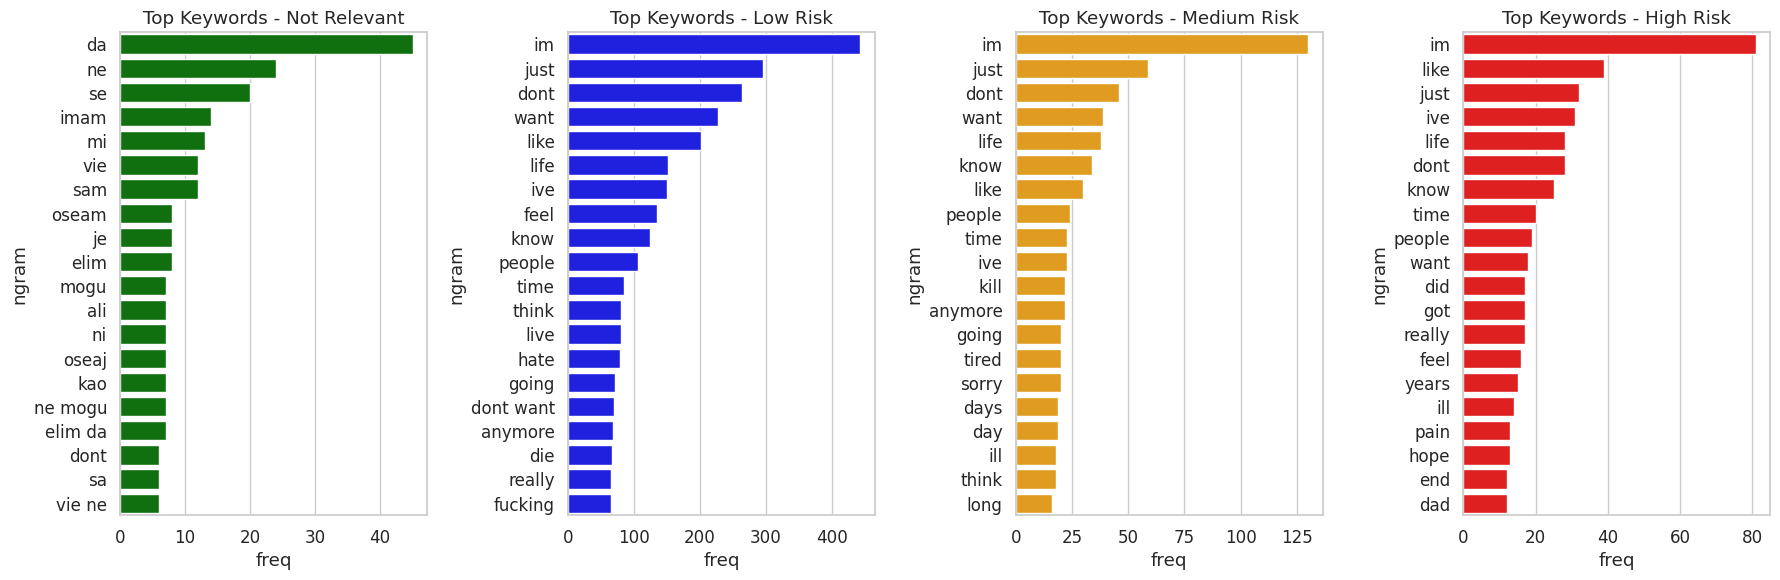

In [79]:
# Plot top keywords per class
fig, axes = plt.subplots(1,4, figsize=(18,6))
sns.barplot(x='freq', y='ngram', data=notr_df, ax=axes[0], color='Green')
axes[0].set_title('Top Keywords - Not Relevant')
sns.barplot(x='freq', y='ngram', data=low_df, ax=axes[1], color='blue')
axes[1].set_title('Top Keywords - Low Risk')
sns.barplot(x='freq', y='ngram', data=medium_df, ax=axes[2], color='orange')
axes[2].set_title('Top Keywords - Medium Risk')
sns.barplot(x='freq', y='ngram', data=high_df, ax=axes[3], color='red')
axes[3].set_title('Top Keywords - High Risk')
plt.tight_layout()
plt.show()

In [80]:
gold_df['timestamp'] = pd.to_datetime(gold_df['timestamp'])

In [81]:
# # Temporal exploration: distribution by hour of day
# gold_df['hour'] = gold_df['timestamp'].dt.hour
# plt.figure(figsize=(10,6))
# sns.countplot(x='hour', hue='label', data=gold_df, palette='viridis')
# plt.title('Posts by Hour and Risk Level')
# plt.xlabel('Hour of Day')
# plt.ylabel('Number of Posts')
# plt.legend(title='Risk Level', labels=['Low','Medium','High'])
# plt.show()

In [82]:
gold_df['hour'] = gold_df['timestamp'].dt.hour  # use .dt.hour

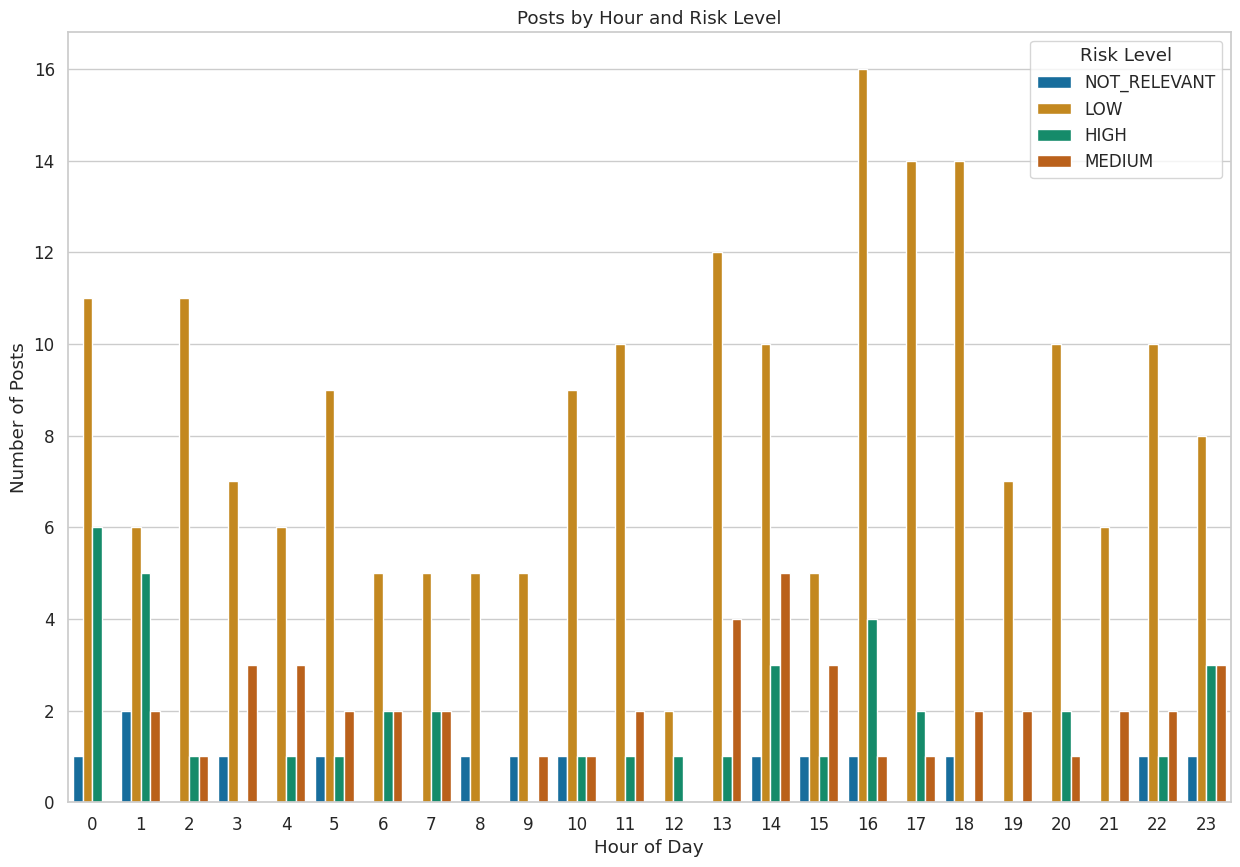

In [83]:
plt.figure(figsize=(15,10))
sns.countplot(x='hour', hue='manual_label', data=gold_df, palette='colorblind')
plt.title('Posts by Hour and Risk Level')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Posts')
plt.legend(title='Risk Level')
plt.show()

In [84]:
# Sentiment proxy: length of post as simple indicator
gold_df['post_length'] = gold_df['clean_text'].apply(lambda x: len(x.split()))


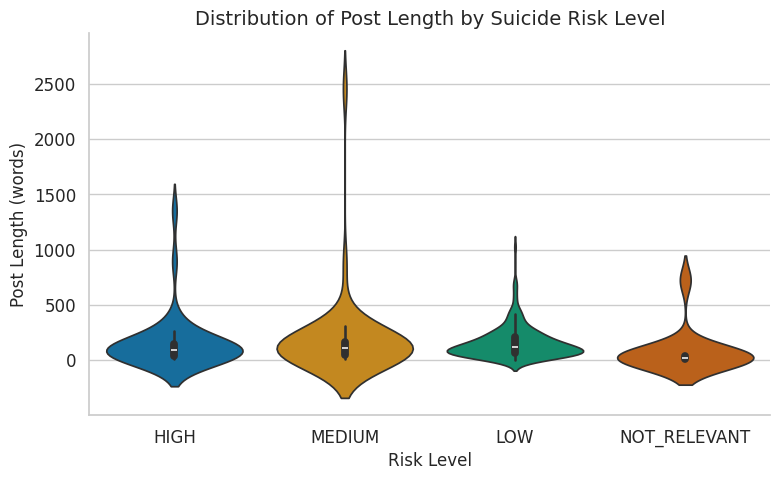

In [85]:
plt.figure(figsize=(8,5))
sns.violinplot(x='manual_label', y='post_length', data=gold_df, palette='colorblind', inner='box')
plt.title('Distribution of Post Length by Suicide Risk Level', fontsize=14)
plt.xlabel('Risk Level', fontsize=12)
plt.ylabel('Post Length (words)', fontsize=12)
sns.despine()
plt.tight_layout()
plt.show()